In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_classification.models.mobilenet import MobileNetV1
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 128

In [3]:
artifact_path = Path("../../artifacts/mobilenet")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

14


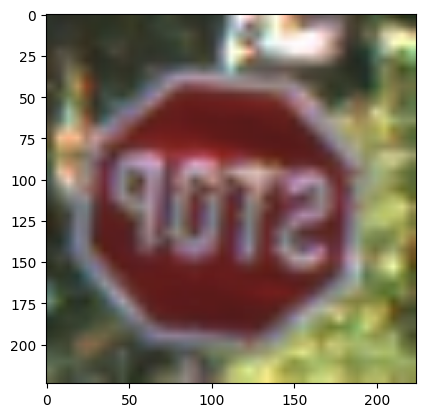

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = MobileNetV1(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
MobileNetV1                                   --
├─Sequential: 1-1                             --
│    └─Conv2dNormActivation: 2-1              --
│    │    └─Conv2d: 3-1                       864
│    │    └─BatchNorm2d: 3-2                  64
│    │    └─ReLU: 3-3                         --
│    └─DepthwiseSeparableConv2d: 2-2          --
│    │    └─ConvBnRelu: 3-4                   352
│    │    └─ConvBnRelu: 3-5                   2,176
│    └─DepthwiseSeparableConv2d: 2-3          --
│    │    └─ConvBnRelu: 3-6                   704
│    │    └─ConvBnRelu: 3-7                   8,448
│    └─DepthwiseSeparableConv2d: 2-4          --
│    │    └─ConvBnRelu: 3-8                   1,408
│    │    └─ConvBnRelu: 3-9                   16,640
│    └─DepthwiseSeparableConv2d: 2-5          --
│    │    └─ConvBnRelu: 3-10                  1,408
│    │    └─ConvBnRelu: 3-11                  33,280
│    └─DepthwiseSeparableConv2d: 2-6     

# training

In [13]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
from torchlake.common.controller.recorder import TrainRecorder

recorder = TrainRecorder(total_epoch=epoches)
recorder.increment_data_size(len(train_dataset))

In [17]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
# for custom start point, comment this line
recorder.reset_epoch()

In [18]:
training_loss = trainer.run(
    train_loader,
    model,
    optim,
    criterion,
    scaler=scaler,
    recorder=recorder,
)

Enable AMP: True
Training...


100%|██████████| 208/208 [01:00<00:00,  3.41it/s]


Epoch 1 : 0.009995490598964978 (0%)


100%|██████████| 208/208 [00:57<00:00,  3.61it/s]


Epoch 2 : 0.002869303547986992 (-71%)


100%|██████████| 208/208 [00:59<00:00,  3.52it/s]


Epoch 3 : 0.0007025141145211752 (-76%)


100%|██████████| 208/208 [00:59<00:00,  3.52it/s]


Epoch 4 : 0.00025542324330929 (-64%)


100%|██████████| 208/208 [00:57<00:00,  3.63it/s]


Epoch 5 : 0.00014097880975513886 (-45%)


100%|██████████| 208/208 [00:57<00:00,  3.61it/s]


Epoch 6 : 0.0001087281619605549 (-23%)


100%|██████████| 208/208 [01:02<00:00,  3.33it/s]


Epoch 7 : 7.112841677709336e-05 (-35%)


100%|██████████| 208/208 [00:55<00:00,  3.73it/s]


Epoch 8 : 9.642238594107785e-05 (36%)


100%|██████████| 208/208 [00:58<00:00,  3.53it/s]


Epoch 9 : 7.436790586765236e-05 (-23%)


100%|██████████| 208/208 [00:58<00:00,  3.54it/s]

Epoch 10 : 4.426032974588888e-05 (-40%)


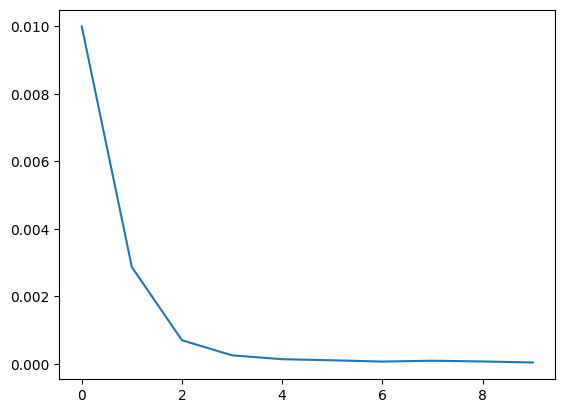

In [19]:
plt.plot(training_loss)

# inference

In [20]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [21]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [22]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [23]:
evaluator = ClassificationEvaluator(num_class, device)

In [24]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 99/99 [02:40<00:00,  1.62s/it]

[[ 40  20   0 ...   0   0   0]
 [  2 692  11 ...   0   0   0]
 [  0  13 720 ...   0   0   0]
 ...
 [  0   0   0 ...  60   0   0]
 [  0   0   0 ...   0  38   5]
 [  0   0   0 ...   0  14  72]]


In [25]:
print(confusion_matrix)

[[ 40  20   0 ...   0   0   0]
 [  2 692  11 ...   0   0   0]
 [  0  13 720 ...   0   0   0]
 ...
 [  0   0   0 ...  60   0   0]
 [  0   0   0 ...   0  38   5]
 [  0   0   0 ...   0  14  72]]


In [26]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.6666666666666666
1         : 0.9611111111111111
2         : 0.96
3         : 0.8911111111111111
4         : 0.946969696969697
5         : 0.8698412698412699
6         : 0.7933333333333333
7         : 0.8533333333333334
8         : 0.8377777777777777
9         : 0.9979166666666667
10        : 0.9984848484848485
11        : 0.9547619047619048
12        : 0.9565217391304348
13        : 0.9944444444444445
14        : 0.9703703703703703
15        : 0.9904761904761905
16        : 0.9466666666666667
17        : 0.8944444444444445
18        : 0.823076923076923
19        : 0.4666666666666667
20        : 0.6555555555555556
21        : 0.4777777777777778
22        : 0.7416666666666667
23        : 0.7466666666666667
24        : 0.9666666666666667
25        : 0.9333333333333333
26        : 0.9055555555555556
27        : 0.5
28        : 0.9533333333333334
29        : 0.7555555555555555
30        : 0.32666666666666666
31        : 0.9703703703703703
32        : 0.9833333333333333
33     

In [27]:
per_class_acc.mean()

0.8197189929962931

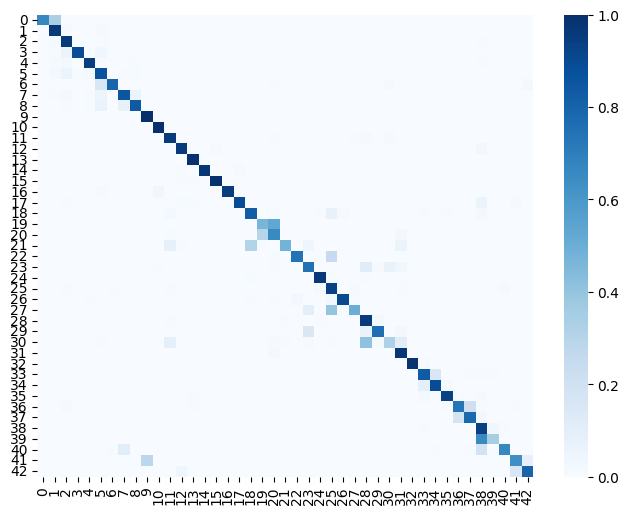

In [28]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

# file

In [29]:
from torchlake.common.controller.weight_manager import WeightManager

In [ ]:
manager = WeightManager(artifact_path.joinpath('mobilenetV1.{epoch}.pth').as_posix())

In [ ]:
filename = manager.get_filename(epoch=recorder.current_epoch)

In [35]:
manager.save_weight(model.state_dict(), filename)

Save weight to ..\..\artifacts\mobilenet\mobilenetV1.10.pth, model size is 12.54MiB


In [36]:
manager.load_weight(filename, model)